In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from itertools import cycle
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## Simulate with metric following normal distribution

In [4]:
mean = 500
stdev = 100 #standard deviation
n = 100000

In [14]:
100000/333

300.3003003003003

In [5]:
values = np.random.normal(mean,stdev,n) #randomly generate numbers from normal distribution

In [6]:
values[:10]

array([375.18495036, 528.25586581, 453.4193882 , 473.52058546,
       536.01470225, 652.5356191 , 460.50708916, 421.01513685,
       725.05396517, 566.404366  ])

In [7]:
def get_stdev_jk(array, num_buckets):
    n = len(array)
    df = pd.DataFrame(array,columns=['metric'])
    df = df.sample(frac=1)
    df.loc[:,'count'] = 1
    seq = cycle([x for x in range(num_buckets)])
    df.loc[:,'bucket'] = [next(seq) for count in range(n)]
    dfagg = df.groupby('bucket').sum().reset_index()
    metric_sum = dfagg['metric'].sum()
    dfagg['bucketed_metric'] = (metric_sum - dfagg['metric']) / (n-dfagg['count'])
    dfagg.set_index('bucket',inplace=True)
    bucketed_metric = dfagg['bucketed_metric']
    m = bucketed_metric.mean()
    return np.sqrt(np.square(bucketed_metric - m).sum()
                   * (num_buckets - 1) / num_buckets                )
    

In [8]:
theoretical_stderr = stdev / n**0.5 #stderr means standard error

In [12]:
jackknife_stderr_estimates = []
num_iter = 40
#num_buckets=30
for num_buckets in range(5000,20000,1000):
    for _ in range(num_iter):
        jackknife_stderr_estimates.append(get_stdev_jk(values,num_buckets))
    mean_est = np.mean(jackknife_stderr_estimates)
    mean_abs_dev = np.mean(np.absolute(jackknife_stderr_estimates - mean_est))/mean_est
    print(num_buckets, mean_abs_dev)



5000 0.008086600510421881
6000 0.00760730796934772
7000 0.007267116111562348
8000 0.006815958727020966
9000 0.006739827552543775
10000 0.006474904146900419
11000 0.006143411899677786
12000 0.006070681098946428
13000 0.00585385891286635
14000 0.005705759178367892
15000 0.0055333496160608975
16000 0.005397065713358815
17000 0.0053282863945771875
18000 0.005226419253200798
19000 0.005152146552815742


## Redo using pareto distribution

In [227]:
pareto_shape = 0.3
n = 10000

In [228]:
mean, var = stats.genpareto.stats(pareto_shape,moments='mv')

In [238]:
theoretical_stderr = float(var)**.5 / n**.5

In [230]:
values = stats.genpareto.rvs(pareto_shape,size=n)

(array([9.573e+03, 3.450e+02, 4.900e+01, 2.100e+01, 8.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([2.31384354e-05, 5.20307955e+00, 1.04061360e+01, 1.56091924e+01,
        2.08122488e+01, 2.60153052e+01, 3.12183616e+01, 3.64214180e+01,
        4.16244744e+01, 4.68275308e+01, 5.20305873e+01]),
 <a list of 10 Patch objects>)

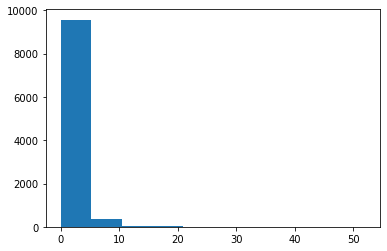

In [231]:
_, ax = plt.subplots(facecolor='w')
ax.hist(values)

Average stderr estimated by jackknife (avg across 500 iterations, 30 buckets per iter) is 0.0212
 ...which is close to the theoretical stderr (0.022587697572631283)
The mean absolute deviation (%) from the above is:
      10.68%.
      I.e. on average, the estimate of the stderr is off by the above amount.
The 95% empirical confidence interval (CI) of the stderr estimate is:
          [0.0164,0.0271]
      yes, this is kind of like showing the CI of the CI. 
If we hypothetically ran jackknife once resulting in a stderr estimate at the low end of this 
confidence interval, and then ran it again resulting in a stderr estimate at the high end, then the change in 
stderr estimate would be:
+64.79%

The variance in stderr estimate is caused by shuffling the data before each iteration.


(array([  2.,   8.,  52., 103., 151., 105.,  57.,  15.,   6.,   1.]),
 array([0.01178769, 0.01382799, 0.01586828, 0.01790857, 0.01994886,
        0.02198916, 0.02402945, 0.02606974, 0.02811003, 0.03015032,
        0.03219062]),
 <a list of 10 Patch objects>)

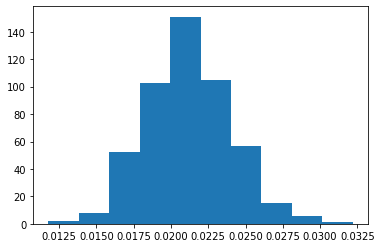

In [248]:
jackknife_stderr_estimates = []
num_iter = 500
num_buckets=30
for _ in range(num_iter):
    jackknife_stderr_estimates.append(get_stdev_jk(values,num_buckets))
mean_est = np.mean(jackknife_stderr_estimates)
print(f"Average stderr estimated by jackknife (avg across {num_iter} iterations, {num_buckets} buckets per iter) is {round(mean_est,5)}")
print(f" ...which is close to the theoretical stderr ({theoretical_stderr})")
print(f"""The mean absolute deviation (%) from the above is:
      {round(100*np.mean(np.absolute(jackknife_stderr_estimates - mean_est))/mean_est,3)}%.
      I.e. on average, the estimate of the stderr is off by the above amount.""")
print(f"""The 95% empirical confidence interval (CI) of the stderr estimate is:
          [{round(np.percentile(jackknife_stderr_estimates,2.5),4)},{round(np.percentile(jackknife_stderr_estimates,97.5),4)}]
      yes, this is kind of like showing the CI of the CI. """)
print(f"""If we hypothetically ran jackknife once resulting in a stderr estimate at the low end of this 
confidence interval, and then ran it again resulting in a stderr estimate at the high end, then the change in 
stderr estimate would be:
+{round(100*np.percentile(jackknife_stderr_estimates,97.5)/np.percentile(jackknife_stderr_estimates,2.5)-100,2)}%
""")
print("""The variance in stderr estimate is caused by shuffling the data before each iteration.""")
_, ax = plt.subplots(facecolor='w')
ax.hist(jackknife_stderr_estimates)
